In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()

In [3]:
df = pd.read_excel('../dataset/hchi_ratio.xlsx')
df = df.reset_index()
df.head()

,index,dates,HC,HI,HCHI
0,0,2018-11-07 17:15:00,10671,26164,0.407850
1,1,2018-11-07 17:16:00,10725,26263,0.408369
2,2,2018-11-07 17:17:00,10726,26262,0.408423
3,3,2018-11-07 17:18:00,10727,26269,0.408352
4,4,2018-11-07 17:19:00,10733,26274,0.408503


In [6]:
TEST_SIZE = 1440 # minutes

In [19]:
df_mth.head

<bound method NDFrame.head of                      index     HC     HI      HCHI
dates                                             
2018-12-01 00:00:00  14503  10639  26520  0.401169
2018-12-01 00:01:00  14504  10633  26507  0.401139
2018-12-01 00:02:00  14505  10640  26524  0.401146
2018-12-01 00:03:00  14506  10638  26520  0.401131
2018-12-01 00:04:00  14507  10636  26514  0.401147
2018-12-01 00:05:00  14508  10635  26515  0.401094
2018-12-01 00:06:00  14509  10634  26510  0.401132
2018-12-01 00:07:00  14510  10632  26511  0.401041
2018-12-01 00:08:00  14511  10633  26513  0.401049
2018-12-01 00:09:00  14512  10638  26518  0.401161
2018-12-01 00:10:00  14513  10636  26521  0.401041
2018-12-01 00:11:00  14514  10639  26520  0.401169
2018-12-01 00:12:00  14515  10635  26515  0.401094
2018-12-01 00:13:00  14516  10632  26512  0.401026
2018-12-01 00:14:00  14517  10633  26513  0.401049
2018-12-01 00:15:00  14518  10631  26509  0.401034
2018-12-01 00:16:00  14519  10629  26504  0.401034
2

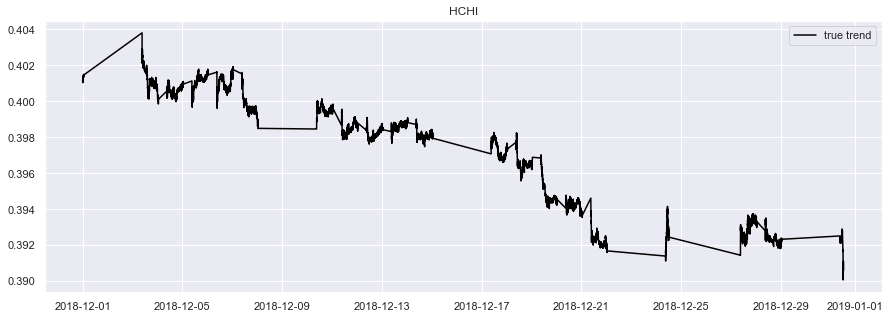

In [28]:
df_bydate = df.set_index(['dates'])
df_mth = df_bydate.loc['2018-12-1':'2018-12-31']

DATASET_SIZE = df_mth.shape[0] # rows

plt.figure(figsize = (15, 5))
plt.plot(df_mth['HCHI'], label = 'true trend', c = 'black')
plt.legend()
plt.title('HCHI')

# date_ori = pd.to_datetime(df_mth.index)
# x_range = np.arange(len(df_mth))
# tick_size = int(DATASET_SIZE / 2)
# plt.xticks(x_range[::tick_size], date_ori[::tick_size])
# plt.gcf().autofmt_xdate()
plt.savefig('HCHI_2018_dec.png')
plt.show()

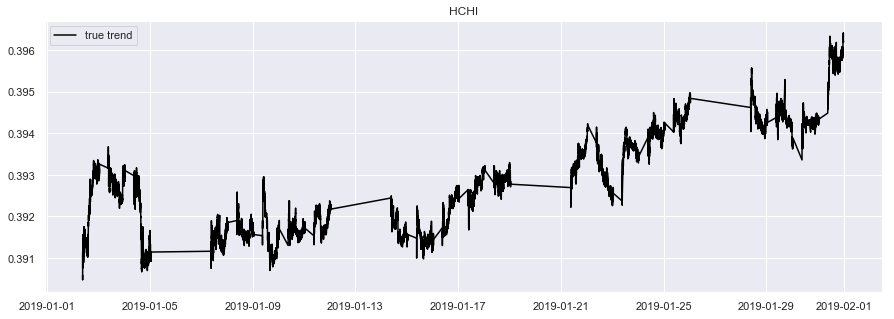

In [29]:
df_mth = df_bydate.loc['2019-1-1':'2019-1-31']

DATASET_SIZE = df_mth.shape[0] # rows

plt.figure(figsize = (15, 5))
plt.plot(df_mth['HCHI'], label = 'true trend', c = 'black')
plt.legend()
plt.title('HCHI')

plt.savefig('HCHI_2019_jan.png')
plt.show()

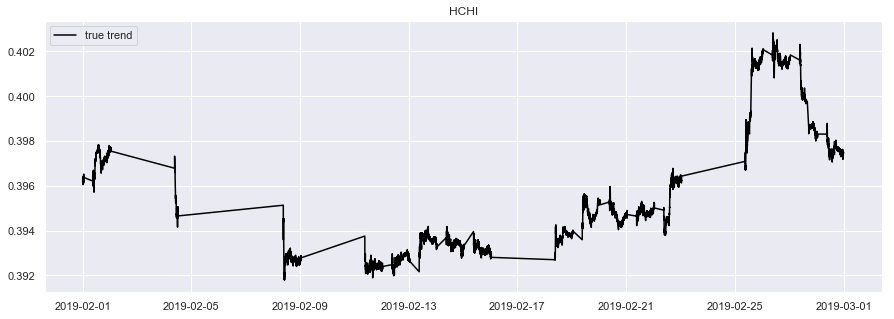

In [30]:
df_mth = df_bydate.loc['2019-2-1':'2019-2-28']

DATASET_SIZE = df_mth.shape[0] # rows

plt.figure(figsize = (15, 5))
plt.plot(df_mth['HCHI'], label = 'true trend', c = 'black')
plt.legend()
plt.title('HCHI')

plt.savefig('HCHI_2019_feb.png')
plt.show()

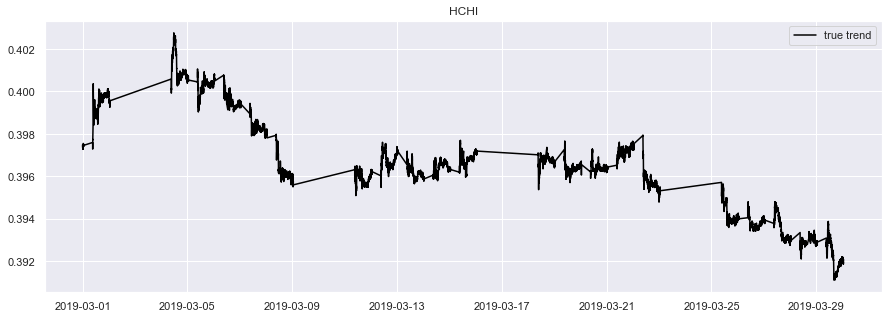

In [31]:
df_mth = df_bydate.loc['2019-3-1':'2019-3-31']

DATASET_SIZE = df_mth.shape[0] # rows

plt.figure(figsize = (15, 5))
plt.plot(df_mth['HCHI'], label = 'true trend', c = 'black')
plt.legend()
plt.title('HCHI')

plt.savefig('HCHI_2019_mar.png')
plt.show()

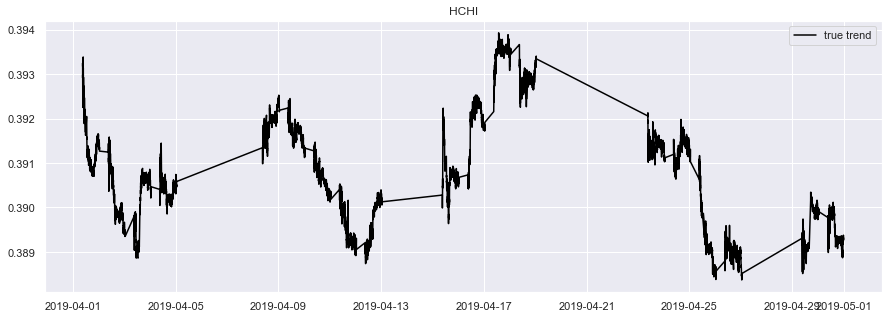

In [32]:
df_mth = df_bydate.loc['2019-4-1':'2019-4-30']

DATASET_SIZE = df_mth.shape[0] # rows

plt.figure(figsize = (15, 5))
plt.plot(df_mth['HCHI'], label = 'true trend', c = 'black')
plt.legend()
plt.title('HCHI')

plt.savefig('HCHI_2019_apr.png')
plt.show()

In [81]:
minmax = MinMaxScaler().fit(df.loc[:DATASET_SIZE - TEST_SIZE - 1, 'HCHI'].astype('float32').values.reshape(-1, 1)) # select HCHI ratio column
df_log = minmax.transform(df.loc[:DATASET_SIZE - TEST_SIZE - 1, 'HCHI'].astype('float32').values.reshape(-1, 1)) # select HCHI ratio column
df_log = pd.DataFrame(df_log)
df_log.shape

(255421, 1)

## Forecast

This example is using model 1.lstm, if you want to use another model, need to tweak a little bit, but I believe it is not that hard.

I want to forecast 30 days ahead! So just change `test_size` to forecast `t + N` ahead.

Also, I want to simulate 10 times, 10 variances of forecasted patterns. Just change `simulation_size`.

In [82]:
simulation_size = 1
num_layers = 1
size_layer = 128
timestamp = 180
epoch = 100
dropout_rate = 0.8
test_size = TEST_SIZE
learning_rate = 0.08

df_train = df_log
df.shape, df_train.shape

((256861, 5), (255421, 1))

In [156]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real)
    predict = np.array(predict)
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [157]:
from math import log10, floor
round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1)) 

In [158]:
from tensorflow.python.framework import ops

def forecast():
    ops.reset_default_graph()
#     tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    last_cost = 0.1    
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        current_cost = np.mean(total_loss)
        print(current_cost)
        pbar.set_postfix(cost = current_cost, acc = np.mean(total_acc))
        if round_to_n(current_cost, 4) == round_to_n(last_cost, 4):
            break
        last_cost = current_cost

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [159]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '









train loop:   0%|                                                 | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Sanity check

Some of our models might not have stable gradient, so forecasted trend might really hangwired. You can use many methods to filter out unstable models.

This method is very simple,
1. If one of element in forecasted trend lower than min(original trend).
2. If one of element in forecasted trend bigger than max(original trend) * 2.

If both are true, reject that trend.

In [76]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['HCHI'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['HCHI']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

1

In [77]:
results_frame = pd.DataFrame(accepted_results)
results_frame = results_frame.transpose() 

results_frame['Dates'] = date_ori
results_frame['Avg'] = np.mean(results_frame, axis=1)
cols = results_frame.columns.tolist()
cols = cols[-2:] + cols[:-2] # reorder columns
results_frame = results_frame[cols] 

results_frame.to_excel('./HCHI_predictions_3hr.xlsx')
results_frame.head

<bound method NDFrame.head of                     Dates       Avg         0
0     2018-11-07 17:15:00  0.407850  0.407850
1     2018-11-07 17:16:00  0.405220  0.405220
2     2018-11-07 17:17:00  0.405213  0.405213
3     2018-11-07 17:18:00  0.405330  0.405330
4     2018-11-07 17:19:00  0.405382  0.405382
5     2018-11-07 17:20:00  0.405427  0.405427
6     2018-11-07 17:21:00  0.405420  0.405420
7     2018-11-07 17:22:00  0.405419  0.405419
8     2018-11-07 17:23:00  0.405398  0.405398
9     2018-11-07 17:24:00  0.405391  0.405391
10    2018-11-07 17:25:00  0.405398  0.405398
11    2018-11-07 17:26:00  0.405409  0.405409
12    2018-11-07 17:27:00  0.405425  0.405425
13    2018-11-07 17:28:00  0.405418  0.405418
14    2018-11-07 17:29:00  0.405423  0.405423
15    2018-11-07 17:30:00  0.405415  0.405415
16    2018-11-07 17:31:00  0.405427  0.405427
17    2018-11-07 17:32:00  0.405426  0.405426
18    2018-11-07 17:33:00  0.405430  0.405430
19    2018-11-07 17:34:00  0.405438  0.405438
20  

average train accuracy: 99.5672 
 average test accuracy: 99.7725


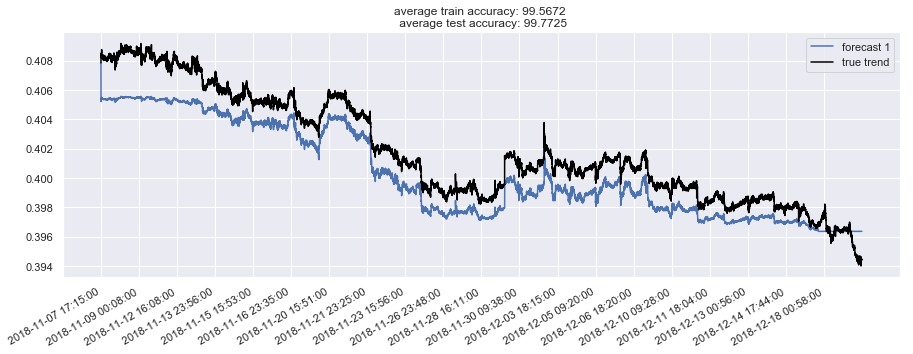

In [78]:
train_accuracies = [calculate_accuracy(df.loc[:DATASET_SIZE - TEST_SIZE - 1, 'HCHI'].values, r[:DATASET_SIZE - TEST_SIZE]) for r in accepted_results]
test_accuracies = [calculate_accuracy(df.loc[DATASET_SIZE - TEST_SIZE:, 'HCHI'].values, r[DATASET_SIZE - TEST_SIZE:]) for r in accepted_results]
avg_train_acc = np.mean(train_accuracies)
avg_test_acc = np.mean(test_accuracies)
accuracy_statement = 'average train accuracy: {0:.4f} \n average test accuracy: {1:.4f}'.format(avg_train_acc, avg_test_acc)
print(accuracy_statement)

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['HCHI'], label = 'true trend', c = 'black')
plt.legend()
plt.title(accuracy_statement)

x_range_future = np.arange(len(results[0]))
tick_size = int(DATASET_SIZE / 20)
plt.xticks(x_range_future[::tick_size], date_ori[::tick_size])
plt.gcf().autofmt_xdate()
plt.savefig('HCHI_predictions_3hr.png')
plt.show()